# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random

import matplotlib.pyplot as plt
from math import sqrt

In [2]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric

from torch_scatter import scatter
import torch_geometric.utils as U

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 4.7 MB/s eta 0:00:00


# Hyperparameters

In [3]:
# Define the hyperparameters we are going to use:
training_params = {
    'num_graphs': 100,
    'num_classes': 5,
    'mode': 'cycle', # the mode should be 'cycle' or 'path'
    'num_epochs': 100,
    'num_folds': 10,
    'loss_fn': nn.CrossEntropyLoss(reduction='mean'),
}

gnn_params = {
    'input_dim': training_params['num_classes'],
    'hidden_dim': 128,
    'output_dim': training_params['num_classes'],
    'num_layers': 4,
    'drop_ratio': 0.1,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'act_fun': F.relu,
    'batch_size': 64
}



# Data

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def create_line_adj_matrix(num_nodes):
    start_points = list(range(num_nodes-1))
    end_points = list(range(1,num_nodes))
    edge_index = torch.tensor([start_points, end_points])
    return U.to_dense_adj(edge_index).squeeze(0)

def create_cycle_adj_matrix(num_nodes):
    start_points = list(range(num_nodes))
    end_points = list(range(1,num_nodes))+[0]
    edge_index = torch.tensor([start_points, end_points])
    return U.to_dense_adj(edge_index).squeeze(0)

# Generate the dataset
#num_nodes_per_graph = [5 for i in range(training_params['num_graphs'])]
num_nodes_per_graph = [random.randrange(2, 6) for i in range(training_params['num_graphs'])]
if training_params['mode'] == 'path':
    adj_matrices = np.array([create_line_adj_matrix(num_nodes) for num_nodes in num_nodes_per_graph])
elif training_params['mode'] == 'cycle':
    adj_matrices = np.array([create_cycle_adj_matrix(num_nodes) for num_nodes in num_nodes_per_graph])
y_labels = np.array([torch.randint(0,training_params['num_classes'],(num_nodes,)) for num_nodes in num_nodes_per_graph])
x_features = np.array([F.one_hot(y, training_params['num_classes']) for y in y_labels])

# Shuffle the data
p = np.random.permutation(len(x_features))
adj_matrices = list(adj_matrices[p])
x_features = list(x_features[p])
y_labels = list(y_labels[p])

adj_matrices = [x.to(device) for x in adj_matrices]
x_features = [x.float().to(device) for x in x_features]
y_labels = [torch.squeeze(y).to(device) for y in y_labels]

<ipython-input-4-b34ea3ecc4c9>:21: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  adj_matrices = np.array([create_cycle_adj_matrix(num_nodes) for num_nodes in num_nodes_per_graph])
<ipython-input-4-b34ea3ecc4c9>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adj_matrices = np.array([create_cycle_adj_matrix(num_nodes) for num_nodes in num_nodes_per_graph])
<ipython

# Models

## MPNN

In [5]:
class GNNLayer(nn.Module):
    def __init__(self, hidden_dim, use_self_loops, use_self_map):
        super().__init__()
        self.use_self_loops = use_self_loops
        self.use_self_map = use_self_map

        self.mlp = torch.nn.Sequential(torch.nn.Linear(hidden_dim, 2*hidden_dim), torch.nn.BatchNorm1d(2*hidden_dim),
                                       torch.nn.ReLU(), torch.nn.Linear(2*hidden_dim, hidden_dim))
        self.eps = torch.nn.Parameter(torch.Tensor([0]), requires_grad=True) if self.use_self_map else -2

    def add_self_loops(self, adj_matrix):
        identity = torch.eye(*adj_matrix.shape).to(device)
        return adj_matrix + identity

    def forward(self, node_embeddings, adj_matrix):
        if self.use_self_loops: adj_matrix = self.add_self_loops(adj_matrix)
        out = self.mlp((2 + self.eps) * node_embeddings + adj_matrix @ node_embeddings)
        return out


In [6]:
class GNNModule(nn.Module):
    def __init__(self, use_self_loops, use_self_map, depth, drop_ratio):

        super().__init__()
        self.act_fun = gnn_params['act_fun']
        self.use_self_loops = use_self_loops
        self.use_self_map = use_self_map

        self.drop_ratio = drop_ratio
        self.first_layer = nn.Linear(gnn_params['input_dim'], gnn_params['hidden_dim'])

        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        # If we have any hidden layers, add them
        for _ in range(depth):
            self.hidden_layers.append(GNNLayer(gnn_params['hidden_dim'], use_self_loops, use_self_map))
            self.batch_norms.append(torch.nn.BatchNorm1d(gnn_params['hidden_dim']))

        self.last_layer = nn.Linear(gnn_params['hidden_dim'], gnn_params['output_dim'])

    def forward(self, x, adj_matrix):
        x = self.first_layer(x)
        h_list = []

        for i, l in enumerate(self.hidden_layers):
            prev_h = h_list[-1] if i > 0 else x
            h = l(prev_h, adj_matrix)
            h = self.batch_norms[i](h)

            if i != len(self.hidden_layers)-1:
                h = F.dropout(F.relu(h), self.drop_ratio, training = self.training)
            else:
                h = F.dropout(h, self.drop_ratio, training = self.training)

            if i > 0: h = prev_h + h

            h_list.append(h)
        node_representation = 0
        for h in h_list:
            node_representation += h
        node_representation = self.last_layer(node_representation)

        return node_representation


## Model Wrapper Class

In [7]:
class Model:
    def __init__(self, name, module, optimiser):
        self.name = name
        self.module = module
        self.optimiser = optimiser

        self.test_losses = []
        self.test_accuracies = []
        self.training_losses = []
        self.training_accuracies = []

    def update(self, test_loss, test_accuracy, training_loss, training_accuracy):
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_accuracy)
        self.training_losses.append(training_loss)
        self.training_accuracies.append(training_accuracy)



## Create Model

In [8]:
def create_gnn_model (name, use_self_loops, use_self_map):
    if use_self_map:
        gnn_module = GNNModule(use_self_loops=use_self_loops, use_self_map=use_self_map, depth=1, drop_ratio=0).to(device)
    else:
        gnn_module = GNNModule(use_self_loops=use_self_loops, use_self_map=use_self_map, depth=gnn_params['num_layers'], drop_ratio=gnn_params['drop_ratio']).to(device)
    gnn_optimiser = torch.optim.Adam(gnn_module.parameters(), lr=gnn_params['learning_rate'], weight_decay=gnn_params['weight_decay'])
    return Model(name, gnn_module, gnn_optimiser)

# Training

In [9]:
def graph_mini_batch(node_features,  graph_labels, adjacencies):

    # Implement the function here
    total_num_graphs = len(node_features)
    for this_batch_start_index in range(0, total_num_graphs, gnn_params['batch_size']):
        next_batch_start_index = min(this_batch_start_index+gnn_params['batch_size'], total_num_graphs)
        batch_slice = slice(this_batch_start_index, next_batch_start_index)

        # Place all the adjacency matrices in the slice diagonally to each other
        combined_batch_adj_matrix        = torch.block_diag(*adjacencies[batch_slice])
        combined_batch_features          = torch.cat(node_features[batch_slice])
        combined_batch_labels            = torch.cat(graph_labels[batch_slice])

        nodes_per_graph_in_batch = [len(v) for v in node_features[batch_slice]]

        node_index_to_graph_index_map = torch.cat([
            torch.full((num_nodes_in_graph,1), graph_index) for graph_index, num_nodes_in_graph in enumerate(nodes_per_graph_in_batch)
        ], dim=0)

        yield combined_batch_adj_matrix, combined_batch_features, combined_batch_labels, node_index_to_graph_index_map

## Model Training Iteration

In [10]:
def get_model_outputs_on_data(model, adj_matrix, inputs, labels, node_to_graph_map):
    node_outputs = model.module(inputs, adj_matrix)
    node_votes = torch.argmax(F.softmax(node_outputs, dim = 1), dim=1)

    batch_loss = training_params['loss_fn'](node_outputs, labels)
    batch_accuracy = torch.sum(node_votes == labels).item()/len(labels)

    return batch_loss, batch_accuracy

def train_one_epoch(model, train_features, train_labels, train_matrices):
    batch_losses = []
    batch_accuracies = []

    model.module.train()
    for adj_matrix, inputs, labels, node_to_graph_map in graph_mini_batch(train_features, train_labels, train_matrices):
        loss, accuracy = get_model_outputs_on_data(model, adj_matrix, inputs, labels, node_to_graph_map)

        model.optimiser.zero_grad()
        loss.backward()
        model.optimiser.step()

        batch_losses.append(loss.item())
        batch_accuracies.append(accuracy)

        print(f'    loss: {loss.item()} acc: {accuracy}')

    return np.mean(batch_losses), np.mean(batch_accuracies)


## Model Testing Iteration

In [11]:
def test_model(model, test_features, test_labels, test_matrices):
    total_loss = 0.
    all_accuracies = []
    all_losses = []
    model.module.eval()
    with torch.no_grad():
        for adj_matrix, inputs, labels, node_to_graph_map in graph_mini_batch(test_features, test_labels, test_matrices):
            loss, accuracy = get_model_outputs_on_data(model, adj_matrix, inputs, labels, node_to_graph_map)
            all_losses.append(loss.item())
            all_accuracies.append(accuracy)

    avg_loss = np.mean(all_losses)
    avg_accuracy = np.mean(all_accuracies)

    return avg_loss, avg_accuracy


## Training Loop

In [12]:
def train_over_fold(train_pairs, test_pairs, train_matrices, test_matrices):
    train_features = [pair[0] for pair in train_pairs]
    train_labels = [pair[1] for pair in train_pairs]

    test_features = [pair[0] for pair in test_pairs]
    test_labels = [pair[1] for pair in test_pairs]

    for epoch in range(training_params['num_epochs']):
        print('EPOCH {}:'.format(epoch + 1))
        for model in all_models:
            print(f'  {model.name}:')
            avg_training_loss, training_accuracy = train_one_epoch(model, train_features, train_labels, train_matrices)
            avg_test_loss, test_accuracy = test_model(model, test_features, test_labels, test_matrices)
            model.update(avg_test_loss, test_accuracy, avg_training_loss, training_accuracy)
            print(f'    {model.name} TEST LOSS {avg_test_loss} TEST ACC {test_accuracy}')

data_pairs = list(zip(x_features, y_labels))

fold_size = len(data_pairs)//training_params['num_folds']
split_start_points = [i*fold_size for i in range(training_params['num_folds'])]

all_train_losses = [[],[],[],[]]
all_train_accuracies = [[],[],[],[]]

all_test_losses = [[],[],[],[]]
all_test_accuracies = [[],[],[],[]]

for split_start_point in split_start_points:
    split_end_point = min(split_start_point + fold_size, len(data_pairs))
    test_pairs = data_pairs[split_start_point:split_end_point]
    train_pairs = data_pairs[:split_start_point] + data_pairs[split_end_point:]

    test_matrices = adj_matrices[split_start_point:split_end_point]
    train_matrices = adj_matrices[:split_start_point] + adj_matrices[split_end_point:]

    # create the models
    all_models = []
    all_models.append(create_gnn_model(name='No self-loops, no self-map', use_self_loops=False, use_self_map=False))
    all_models.append(create_gnn_model(name='No self-loops, with self-map', use_self_loops=False, use_self_map=True))
    all_models.append(create_gnn_model(name='With self-loops, no self-map', use_self_loops=True, use_self_map=False))
    all_models.append(create_gnn_model(name='With self-loops, with self-map', use_self_loops=True, use_self_map=True))

    # do the training
    train_over_fold(train_pairs, test_pairs, train_matrices, test_matrices)

    for i, model in enumerate(all_models):
        all_test_losses[i].append(model.test_losses)
        all_test_accuracies[i].append(model.test_accuracies)
        all_train_losses[i].append(model.training_losses)
        all_train_accuracies[i].append(model.training_accuracies)



Streaming output truncated to the last 5000 lines.
    loss: 0.36047476530075073 acc: 1.0
    With self-loops, with self-map TEST LOSS 1.0610545873641968 TEST ACC 1.0
EPOCH 7:
  No self-loops, no self-map:
    loss: 2.0442707538604736 acc: 0.30701754385964913
    loss: 1.7154512405395508 acc: 0.40229885057471265
    No self-loops, no self-map TEST LOSS 1.8510135412216187 TEST ACC 0.16129032258064516
  No self-loops, with self-map:
    loss: 0.4909454882144928 acc: 1.0
    loss: 0.42833665013313293 acc: 1.0
    No self-loops, with self-map TEST LOSS 1.1648409366607666 TEST ACC 1.0
  With self-loops, no self-map:
    loss: 1.4603722095489502 acc: 0.44298245614035087
    loss: 1.1339510679244995 acc: 0.5287356321839081
    With self-loops, no self-map TEST LOSS 1.7342751026153564 TEST ACC 0.12903225806451613
  With self-loops, with self-map:
    loss: 0.3260568082332611 acc: 1.0
    loss: 0.2844204008579254 acc: 1.0
    With self-loops, with self-map TEST LOSS 0.9356977343559265 TEST ACC 

# Results

In [13]:
def plot_results(all_model_values, all_model_stds, title, xlabel, ylabel):
    for i, model in enumerate(all_models):
        values = all_model_values[i]
        error = all_model_stds[i]/sqrt(training_params['num_folds'])
        xs = range(1,len(values)+1)
        color = plt.plot(xs, values, label=f'{model.name}')[0].get_color()
        plt.fill_between(xs, values-error, values+error, color=color, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


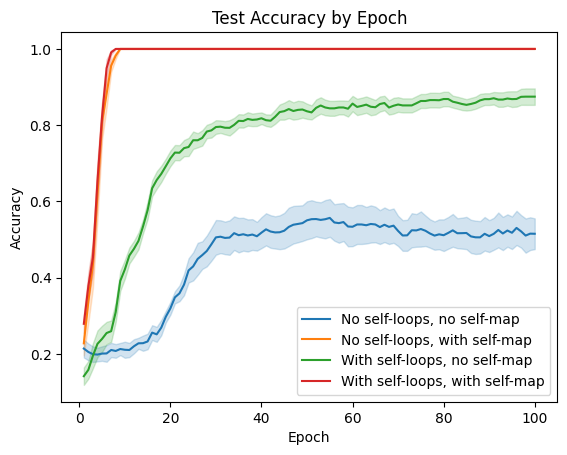

In [14]:
average_train_losses = np.mean(all_train_losses, axis=1)
std_train_losses = np.std(all_train_losses, axis=1)
average_train_accuracies = np.mean(all_train_accuracies, axis=1)
std_train_accuracies = np.std(all_train_accuracies, axis=1)

average_test_losses = np.mean(all_test_losses, axis=1)
std_test_losses = np.std(all_test_losses, axis=1)
average_test_accuracies = np.mean(all_test_accuracies, axis=1)
std_test_accuracies = np.std(all_test_accuracies, axis=1)

#plot_results(average_test_losses, std_test_losses, 'Test Loss by Epoch', 'Epoch', 'Loss')
#plot_results(average_train_losses, std_train_losses, 'Training Loss by Epoch', 'Epoch', 'Loss')
plot_results(average_test_accuracies, std_test_accuracies, 'Test Accuracy by Epoch', 'Epoch', 'Accuracy')
#plot_results(average_train_accuracies, std_train_accuracies, 'Training Accuracy by Epoch', 'Epoch', 'Accuracy')

for i, model in enumerate(all_models):
    print(f'{model.name} - Best test accuracy:', max(model.test_accuracies))


In [15]:
from itertools import chain

for model in all_models:
    total_params = sum(p.numel() for p in model.module.parameters())
    print(model.name, total_params)


No self-loops, no self-map - Best test accuracy: 0.4444444444444444
No self-loops, with self-map - Best test accuracy: 1.0
With self-loops, no self-map - Best test accuracy: 0.8611111111111112
With self-loops, with self-map - Best test accuracy: 1.0
No self-loops, no self-map 268165
No self-loops, with self-map 68102
With self-loops, no self-map 268165
With self-loops, with self-map 68102
